In [1]:
from ema_workbench import save_results, ema_logging
from ema_workbench.util.utilities import load_results
import numpy as np
import pandas as pd
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from dike_model_function import DikeNetwork  # @UnresolvedImport
from ema_workbench import (Model, RealParameter, ScalarOutcome, 
                           MultiprocessingEvaluator, SequentialEvaluator, ema_logging,
                           Scenario, Policy)

from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)

from problem_formulation import get_model_for_problem_formulation

from ema_workbench.analysis import parcoords, prim

dike_model, planning_steps = get_model_for_problem_formulation(7)

In [3]:
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('Evacuation Costs', variable_name=['Expected Evacuation Costs 0', 'Expected Evacuation Costs 1', 'Expected Evacuation Costs 2'], function=<function sum_over at 0x00000280D60BCE58>)
ScalarOutcome('Total investment costs', variable_name=['A.1_Dike Investment Costs 0', 'A.2_Dike Investment Costs 0', 'A.3_Dike Investment Costs 0', 'A.4_Dike Investment Costs 0', 'A.5_Dike Investment Costs 0', 'RfR Total Costs 0', 'A.1_Dike Investment Costs 1', 'A.2_Dike Investment Costs 1', 'A.3_Dike Investment Costs 1', 'A.4_Dike Investment Costs 1', 'A.5_Dike Investment Costs 1', 'RfR Total Costs 1', 'A.1_Dike Investment Costs 2', 'A.2_Dike Investment Costs 2', 'A.3_Dike Investment Costs 2', 'A.4_Dike Investment Costs 2', 'A.5_Dike Investment Costs 2', 'RfR Total Costs 2'], function=<function sum_over at 0x00000280D60BCE58>)
ScalarOutcome('Expected Annual Damage other dike rings', variable_name=['A.1_Expected Annual Damage 0', 'A.2_Expected Annual Damage 0', 'A.4_Expected Annual Damage 0', '

In [4]:
%%time

# Mean values of the ranges, discount rate egalitarian aproach, random id flood wave shape
reference_values = {'Bmax': 190, 'Brate': 1.5, 'pfail': 0.5,
                        'discount rate 0': 1.5, 'discount rate 1': 1.5,
                        'discount rate 2': 1.5,
                        'ID flood wave shape': 14}
scen1 = {}

for key in dike_model.uncertainties:
    name_split = key.name.split('_')

    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name]})

    else:
        scen1.update({key.name: reference_values[name_split[1]]})

ref_scenario = Scenario('reference', **scen1)

convergence_metrics = [EpsilonProgress()]

# espilon = [0.1,] * len(dike_model.outcomes)

# 100 grid cells in objective space per outcome
# Based on max values encountered in open exploration
epsilons = [1e5/1000 , 3.55e9/1000, 5.45e9/1000, 3.53/1000, 2e9/1000, 2.5/1000]
epsilons_2 = [1e5/100 , 3.55e9/100, 5.45e9/100, 3.53/100, 2e9/100, 2.5/100]

nfe = 50000 


# try:
#     # Only run the experiments again if data hasn't been generated yet
#     results = pd.read_csv("results/1000_results_opt_ref.csv")
#     convergence = pd.read_csv("results/1000_convergence_opt_ref.csv")
# except IOError:
#     with MultiprocessingEvaluator(dike_model) as evaluator:
#         results, convergence = evaluator.optimize(nfe=nfe, searchover='levers', 
#                                                       convergence=convergence_metrics, 
#                                                       reference=ref_scenario,
#                                                       epsilons=epsilons)      
#     results.to_csv("results/1000_results_opt_ref.csv")
#     convergence.to_csv("results/1000_convergence_opt_ref.csv")


try:
    # Only run the experiments again if data hasn't been generated yet
    results = pd.read_csv("results/100_results_opt_ref.csv")
    convergence = pd.read_csv("results/100_convergence_opt_ref.csv")
except IOError:
    with MultiprocessingEvaluator(dike_model) as evaluator:
        results, convergence = evaluator.optimize(nfe=nfe, searchover='levers', 
                                                      convergence=convergence_metrics, 
                                                      reference=ref_scenario,
                                                      epsilons=epsilons_2)      
    results.to_csv("results/100_results_opt_ref.csv")
    convergence.to_csv("results/100convergence_opt_ref.csv")


Wall time: 15.6 ms


In [5]:
data = results.loc[:, [o.name for o in dike_model.outcomes]]
data

,Evacuation Costs,Total investment costs,Expected Annual Damage other dike rings,Expected Number of Deaths other dike rings,A.3_Expected Annual Damage,A.3_Expected Number of Deaths
0,927.672837,1.418503e+08,4.735714e+07,0.012468,0.000000e+00,0.000000
1,7747.951944,6.787643e+07,2.196049e+08,0.022893,0.000000e+00,0.000000
2,0.000000,6.675510e+07,2.196049e+08,0.152622,0.000000e+00,0.000000
3,0.000000,9.291364e+07,1.248106e+08,0.088502,0.000000e+00,0.000000
4,4667.001642,6.878532e+07,2.196049e+08,0.054944,0.000000e+00,0.000000
5,0.000000,1.003245e+08,7.498032e+07,0.053317,6.257255e+07,0.083286
6,14660.441036,3.269490e+07,2.796541e+08,0.026493,2.366183e+08,0.047194
7,0.000000,3.070000e+07,5.317924e+08,0.291826,0.000000e+00,0.000000
8,4233.345753,9.931322e+07,7.596136e+07,0.008055,6.257255e+07,0.012493
9,5710.426863,6.777404e+07,2.089624e+08,0.052347,7.887277e+07,0.037755


<function matplotlib.pyplot.show(close=None, block=None)>

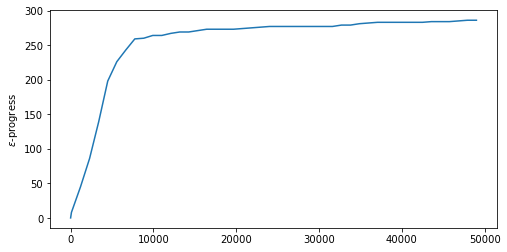

In [6]:
fig, ax = plt.subplots(ncols=1, sharex=True, figsize=(8,4))
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')
plt.show

# Looks converged

will continue to get program running

C:\Users\laszl\Anaconda3\envs\gds\lib\site-packages\ema_workbench\analysis\parcoords.py:198: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(h_pad=0, w_pad=0)


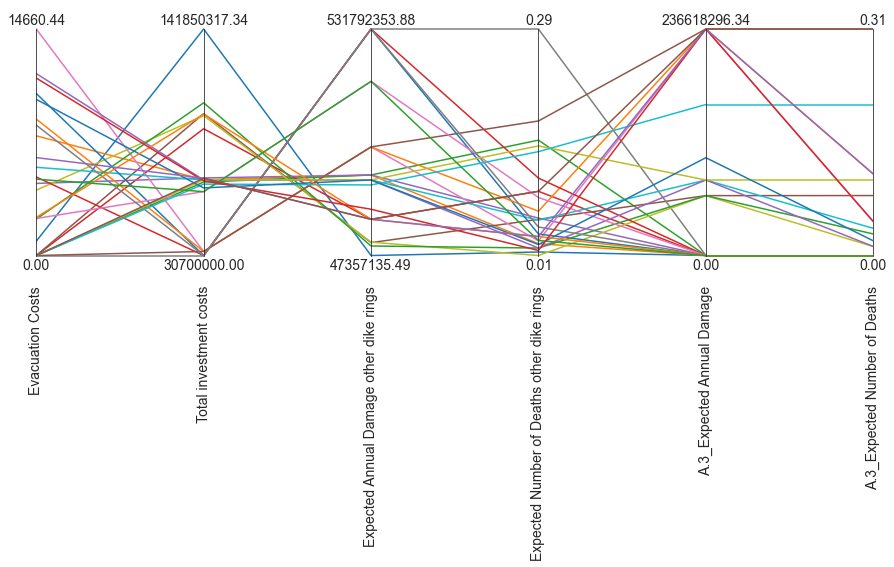

In [7]:
# data = results.loc[:, ['A.3_Expected Annual Damage', 'A.3_Dike Investment Costs', 'A.3_Expected Number of Deaths',
#                        'RfR Total Costs', 'Expected Evacuation Costs']]

limits = parcoords.get_limits(data)
# limits.loc[0, ['A.3_Expected Annual Damage', 'A.3_Dike Investment Costs', 'A.3_Expected Number of Deaths',
#                        'RfR Total Costs', 'Expected Evacuation Costs']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
fig = paraxes.fig
fig.set_size_inches(15,5)
plt.show()

In [8]:
data.columns

Index(['Evacuation Costs', 'Total investment costs',
       'Expected Annual Damage other dike rings',
       'Expected Number of Deaths other dike rings',
       'A.3_Expected Annual Damage', 'A.3_Expected Number of Deaths'],
      dtype='object')

In [9]:
thresholds = results[(results['A.3_Expected Number of Deaths'] < 0.02) & (results["Expected Number of Deaths other dike rings"] < 0.08)  & (results['Evacuation Costs'] < 10000)]
                     #(results["RfR Investment Costs"] < 1e8)]
# thresholds[['A.3_Expected Annual Damage', 'A.3_Dike Investment Costs', 'A.3_Expected Number of Deaths',
#                        'RfR Total Costs', 'Expected Evacuation Costs']]

thresholds.loc[:, [o.name for o in dike_model.outcomes]]

,Evacuation Costs,Total investment costs,Expected Annual Damage other dike rings,Expected Number of Deaths other dike rings,A.3_Expected Annual Damage,A.3_Expected Number of Deaths
0,927.672837,1.418503e+08,4.735714e+07,0.012468,0.000000e+00,0.000000
1,7747.951944,6.787643e+07,2.196049e+08,0.022893,0.000000e+00,0.000000
4,4667.001642,6.878532e+07,2.196049e+08,0.054944,0.000000e+00,0.000000
8,4233.345753,9.931322e+07,7.596136e+07,0.008055,6.257255e+07,0.012493
17,8441.760806,3.070000e+07,5.317924e+08,0.043774,0.000000e+00,0.000000
21,2468.341708,1.001322e+08,1.248106e+08,0.031861,0.000000e+00,0.000000
22,4942.538887,6.205801e+07,4.199570e+08,0.026909,0.000000e+00,0.000000


C:\Users\laszl\Anaconda3\envs\gds\lib\site-packages\ema_workbench\analysis\parcoords.py:198: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(h_pad=0, w_pad=0)
C:\Users\laszl\Anaconda3\envs\gds\lib\site-packages\ema_workbench\analysis\parcoords.py:261: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(h_pad=0, w_pad=0)


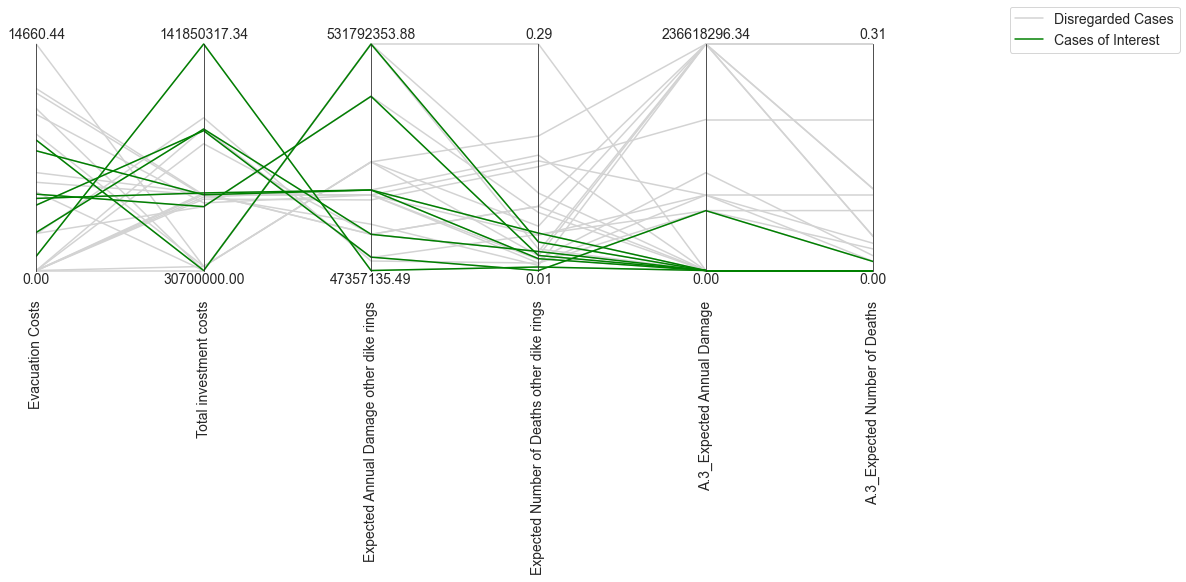

In [10]:
good_policies = thresholds.loc[:, [o.name for o in dike_model.outcomes]]
all_policies =  results.loc[:, [o.name for o in dike_model.outcomes]]

# Plot parcoords
limits = parcoords.get_limits(all_policies)
axes = parcoords.ParallelAxes(limits)
axes.plot(all_policies, color='lightgrey', label="Disregarded Cases")
axes.plot(good_policies, color='green', label="Cases of Interest")
axes.legend()
fig = axes.fig
fig.set_size_inches(15,5)
plt.savefig("Figures/parcoords_ref_scen")
plt.show()

In [11]:
policies = thresholds.drop([o.name for o in dike_model.outcomes], axis=1)
policies

,Unnamed: 0,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,2,0,0,2,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,2,0,0,3,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,3,0,0,2,0,0,0,0,0
8,8,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
17,17,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
21,21,0,0,0,0,0,0,0,0,0,...,0,2,0,0,2,0,0,4,0,0
22,22,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0


In [12]:
from ema_workbench import Policy

policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

## Re-evaluate candidate solutions under uncertainty

In [13]:
n_scenarios = 1000
try:
    results = load_results("results/1000_scen_7_pol.tar.gz")
except IOError:
    with MultiprocessingEvaluator(dike_model) as evaluator:
        results = evaluator.perform_experiments(n_scenarios,
                                                policies_to_evaluate)
    save_results(results, "results/1000_scen_7_pol.tar.gz")

[MainProcess/INFO] results loaded succesfully from C:\Users\laszl\GitHub\MBDM\final assignment\results\1000_scen_7_pol.tar.gz


In [14]:
experiments, outcomes = results

In [15]:
experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,Unnamed: 0
0,111.0,251.127963,1.5,0.516482,150.056004,1.0,0.721501,332.230184,1.5,0.326776,...,2.0,0.0,0.0,2.0,0.0,0.0,1,0,dikesnet,0.0
1,20.0,327.169609,1.0,0.295390,348.255259,10.0,0.660083,151.499452,10.0,0.772382,...,2.0,0.0,0.0,2.0,0.0,0.0,2,0,dikesnet,0.0
2,117.0,148.200269,1.5,0.620312,150.950611,1.0,0.591239,183.467717,1.5,0.872081,...,2.0,0.0,0.0,2.0,0.0,0.0,3,0,dikesnet,0.0
3,73.0,199.385849,1.0,0.296034,88.336192,1.0,0.993765,253.784433,1.0,0.241023,...,2.0,0.0,0.0,2.0,0.0,0.0,4,0,dikesnet,0.0
4,73.0,345.810327,1.0,0.467743,304.475670,10.0,0.504824,260.313988,1.0,0.338239,...,2.0,0.0,0.0,2.0,0.0,0.0,5,0,dikesnet,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,113.0,135.002613,10.0,0.087579,234.967811,1.0,0.464391,206.218095,1.0,0.817885,...,1.0,0.0,0.0,1.0,0.0,0.0,996,22,dikesnet,22.0
6996,32.0,121.788783,1.5,0.688522,225.997265,10.0,0.474330,67.998089,1.0,0.257603,...,1.0,0.0,0.0,1.0,0.0,0.0,997,22,dikesnet,22.0
6997,47.0,189.822052,1.5,0.786009,329.590077,1.5,0.736375,243.132561,10.0,0.218272,...,1.0,0.0,0.0,1.0,0.0,0.0,998,22,dikesnet,22.0
6998,68.0,121.128809,10.0,0.588063,158.887420,1.0,0.482919,204.079739,10.0,0.157328,...,1.0,0.0,0.0,1.0,0.0,0.0,999,22,dikesnet,22.0


# Prim

In [16]:
experiments.dtypes

A.0_ID flood wave shape     float64
A.1_Bmax                    float64
A.1_Brate                  category
A.1_pfail                   float64
A.2_Bmax                    float64
A.2_Brate                  category
A.2_pfail                   float64
A.3_Bmax                    float64
A.3_Brate                  category
A.3_pfail                   float64
A.4_Bmax                    float64
A.4_Brate                  category
A.4_pfail                   float64
A.5_Bmax                    float64
A.5_Brate                  category
A.5_pfail                   float64
discount rate 0            category
discount rate 1            category
discount rate 2            category
0_RfR 0                     float64
0_RfR 1                     float64
0_RfR 2                     float64
1_RfR 0                     float64
1_RfR 1                     float64
1_RfR 2                     float64
2_RfR 0                     float64
2_RfR 1                     float64
2_RfR 2                     

# Search for scenarios where policies have failed
A high deathrate for A.3
Even low evacuation costs are considered as failed, because of the emotional damage they bring to citizens

In [32]:
x = experiments.drop([o.name for o in dike_model.levers], axis=1)
y = (outcomes['A.3_Expected Number of Deaths'] > 0.1) #& (outcomes['Evacuation Costs'] > 500)



#& (outcomes['A.2_Expected Number of Deaths'] > 0.01) \
    #& (outcomes['A.3_Expected Number of Deaths'] > 0.01) & (outcomes['A.4_Expected Number of Deaths'] > 0.01) & (outcomes['A.5_Expected Number of Deaths'] > 0.01)

In [33]:
data = pd.DataFrame.from_dict(outcomes)[y]
data

,Evacuation Costs,Total investment costs,Expected Annual Damage other dike rings,Expected Number of Deaths other dike rings,A.3_Expected Annual Damage,A.3_Expected Number of Deaths
6,15556.917136,1.418503e+08,9.321661e+08,0.215278,5.080665e+08,0.297506
11,13375.865182,1.418503e+08,1.447637e+07,0.005395,5.610320e+08,0.369725
15,40876.415715,1.418503e+08,3.723608e+08,0.111859,1.435382e+09,0.865188
36,20879.376690,1.418503e+08,8.886946e+07,0.028642,8.777609e+08,0.516412
51,18102.725307,1.418503e+08,7.635555e+07,0.018888,5.183423e+08,0.410874
...,...,...,...,...,...,...
6963,95152.663553,6.205801e+07,1.930301e+09,0.175502,1.170532e+09,0.255559
6964,33131.485020,6.205801e+07,9.547997e+07,0.010346,5.062955e+08,0.129235
6966,38359.822279,6.205801e+07,2.708358e+07,0.002973,6.049766e+08,0.153157
6981,68273.712443,6.205801e+07,1.328764e+07,0.001751,1.197973e+09,0.265102


C:\Users\laszl\Anaconda3\envs\gds\lib\site-packages\ema_workbench\analysis\parcoords.py:198: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(h_pad=0, w_pad=0)


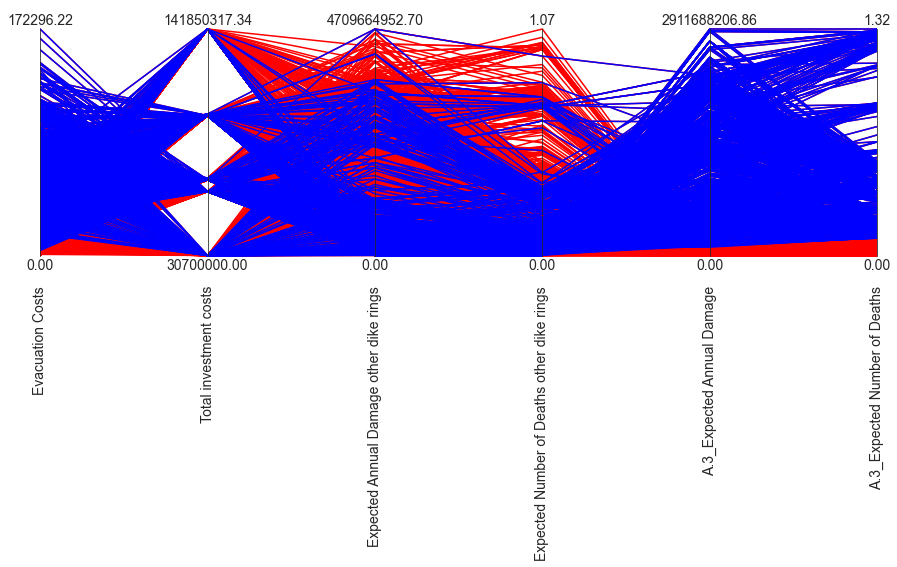

In [29]:
# All scenarios
all_data = pd.DataFrame({k:v for k,v in outcomes.items()})

# Plot parcoords

limits = parcoords.get_limits(all_data)
axes = parcoords.ParallelAxes(limits)
axes.plot(all_data, color='red')
axes.plot(data, color='blue')
fig = axes.fig
fig.set_size_inches(15,5)
plt.show()

In [41]:
x.dtypes

A.0_ID flood wave shape     float64
A.1_Bmax                    float64
A.1_Brate                  category
A.1_pfail                   float64
A.2_Bmax                    float64
A.2_Brate                  category
A.2_pfail                   float64
A.3_Bmax                    float64
A.3_Brate                  category
A.3_pfail                   float64
A.4_Bmax                    float64
A.4_Brate                  category
A.4_pfail                   float64
A.5_Bmax                    float64
A.5_Brate                  category
A.5_pfail                   float64
discount rate 0            category
discount rate 1            category
discount rate 2            category
scenario                   category
policy                     category
model                      category
Unnamed: 0                  float64
dtype: object

In [43]:
# Only works if results are loaded, when results are run category dtype will be object
x_numeric = x.select_dtypes(exclude=pd.CategoricalDtype)
x_categorical = x.select_dtypes(include=pd.CategoricalDtype)

rotated_experiments, rotation_matrix = prim.pca_preprocess(x_numeric, y)

In [44]:
rotated_x = pd.concat([rotated_experiments, x_categorical], axis=1)
rotated_x = rotated_x.drop(columns=['policy'])

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 7000 points remaining, containing 975 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.03742857142857143, coverage: 0.26871794871794874, density: 1.0 restricted_dimensions: 3


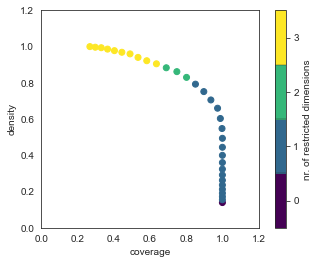

In [45]:
from ema_workbench.analysis.prim_util import PRIMObjectiveFunctions


prim_alg = prim.Prim(rotated_x, y, threshold=0.8, peel_alpha=0.1, mass_min=0.01)
box = prim_alg.find_box()

box.show_tradeoff()
plt.show()

In [46]:
box.peeling_trajectory

,coverage,density,id,mass,mean,res_dim
0,1.000000,0.139286,0,1.000000,0.139286,0
1,1.000000,0.154762,1,0.900000,0.154762,1
2,1.000000,0.171958,2,0.810000,0.171958,1
3,1.000000,0.191064,3,0.729000,0.191064,1
4,1.000000,0.212326,4,0.656000,0.212326,1
5,1.000000,0.235963,5,0.590286,0.235963,1
6,1.000000,0.262238,6,0.531143,0.262238,1
7,1.000000,0.291393,7,0.478000,0.291393,1
8,1.000000,0.323813,8,0.430143,0.323813,1
9,1.000000,0.359911,9,0.387000,0.359911,1


## box 19 has coverage and density > 0.8

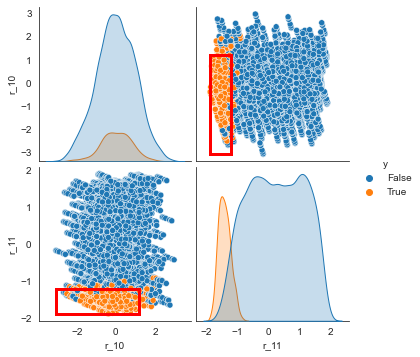

In [47]:
box.show_pairs_scatter(19)
plt.show()

In [48]:
box.inspect(19)

coverage    0.802051
density     0.830149
id                19
mass        0.134571
mean        0.830149
res_dim            2
Name: 19, dtype: object

        box 19                                         
           min       max                      qp values
r_11 -1.886531 -1.217053                    [-1.0, 0.0]
r_10 -3.070576  1.192656  [-1.0, 0.0021794219725611037]



In [49]:
box.select(19)

In [50]:
scen_box = experiments.iloc[box.yi]
outcomes_box = {k:v[box.yi] for k,v in outcomes.items()}

In [51]:
scen_box.dtypes

A.0_ID flood wave shape     float64
A.1_Bmax                    float64
A.1_Brate                  category
A.1_pfail                   float64
A.2_Bmax                    float64
A.2_Brate                  category
A.2_pfail                   float64
A.3_Bmax                    float64
A.3_Brate                  category
A.3_pfail                   float64
A.4_Bmax                    float64
A.4_Brate                  category
A.4_pfail                   float64
A.5_Bmax                    float64
A.5_Brate                  category
A.5_pfail                   float64
discount rate 0            category
discount rate 1            category
discount rate 2            category
0_RfR 0                     float64
0_RfR 1                     float64
0_RfR 2                     float64
1_RfR 0                     float64
1_RfR 1                     float64
1_RfR 2                     float64
2_RfR 0                     float64
2_RfR 1                     float64
2_RfR 2                     

In [52]:
# Change categorical Dtype to object, so results can be loaded
for i in scen_box.select_dtypes(include=pd.CategoricalDtype).columns:
    scen_box[i] = scen_box[i].astype(str)

<ipython-input-52-62d0b6b66d55>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scen_box[i] = scen_box[i].astype(str)


In [53]:
scen_box.dtypes

A.0_ID flood wave shape    float64
A.1_Bmax                   float64
A.1_Brate                   object
A.1_pfail                  float64
A.2_Bmax                   float64
A.2_Brate                   object
A.2_pfail                  float64
A.3_Bmax                   float64
A.3_Brate                   object
A.3_pfail                  float64
A.4_Bmax                   float64
A.4_Brate                   object
A.4_pfail                  float64
A.5_Bmax                   float64
A.5_Brate                   object
A.5_pfail                  float64
discount rate 0             object
discount rate 1             object
discount rate 2             object
0_RfR 0                    float64
0_RfR 1                    float64
0_RfR 2                    float64
1_RfR 0                    float64
1_RfR 1                    float64
1_RfR 2                    float64
2_RfR 0                    float64
2_RfR 1                    float64
2_RfR 2                    float64
3_RfR 0             

In [55]:
save_results((scen_box, outcomes_box), 'results/mordm.tar.gz')

[MainProcess/INFO] results saved successfully to C:\Users\archipel-03\Documents\GitHub\MBDM\final assignment\results\mordm.tar.gz
